<a href="https://colab.research.google.com/github/magenta/mt3/blob/main/mt3/colab/music_transcription_with_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Music Transcription with Transformers

This notebook is an interactive demo of a few [music transcription models](g.co/magenta/mt3) created by Google's [Magenta](g.co/magenta) team.  You can upload audio and have one of our models automatically transcribe it.

<img src="https://magenta.tensorflow.org/assets/transcription-with-transformers/architecture_diagram.png" alt="Transformer-based transcription architecture">

The notebook supports two pre-trained models:
1. the piano transcription model from [our ISMIR 2021 paper](https://archives.ismir.net/ismir2021/paper/000030.pdf)
1. the multi-instrument transcription model from [our ICLR 2022 paper](https://openreview.net/pdf?id=iMSjopcOn0p)

**Caveat**: neither model is trained on singing.  If you upload audio with vocals, you will likely get weird results.  Multi-instrument transcription is still not a completely-solved problem and so you may get weird results regardless.

In any case, we hope you have fun transcribing!  Feel free to tweet any interesting output at [@GoogleMagenta](https://twitter.com/googlemagenta)...

### Instructions for running:

* Make sure to use a GPU runtime, click:  __Runtime >> Change Runtime Type >> GPU__
* Press ▶️ on the left of each cell to execute the cell
* In the __Load Model__ cell, choose either `ismir2021` for piano transcription or `mt3` for multi-instrument transcription
* In the __Upload Audio__ cell, choose an MP3 or WAV file from your computer when prompted
* Transcribe the audio using the __Transcribe Audio__ cell (it may take a few minutes depending on the length of the audio)

---

This notebook sends basic usage data to Google Analytics.  For more information, see [Google's privacy policy](https://policies.google.com/privacy).

In [ ]:
# Copyright 2021 Google LLC. All Rights Reserved.

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#     http://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

#@title Setup Environment
#@markdown Install MT3 and its dependencies (may take a few minutes).

!apt-get update -qq && apt-get install -qq libfluidsynth1 build-essential libasound2-dev libjack-dev

!pip install nest-asyncio
!pip install pyfluidsynth
# pin CLU for python 3.7 compatibility
!pip install clu==0.0.7
# pin Orbax to use Checkpointer
!pip install orbax==0.0.2

# install t5x
!git clone --branch=main https://github.com/google-research/t5x
# pin T5X for python 3.7 compatibility
!cd t5x; git reset --hard 2e05ad41778c25521738418de805757bf2e41e9e; cd ..
!mv t5x t5x_tmp; mv t5x_tmp/* .; rm -r t5x_tmp
!sed -i 's:jax\[tpu\]:jax:' setup.py
!python3 -m pip install -e .

# install mt3
!git clone --branch=main https://github.com/magenta/mt3
!mv mt3 mt3_tmp; mv mt3_tmp/* .; rm -r mt3_tmp
!python3 -m pip install -e .

# downgrade jax and jaxlib
# TODO(iansimon): remove this once we can use the latest t5x
!pip install jax==0.3.15
!pip install jaxlib==0.3.15

# copy checkpoints
!gsutil -q -m cp -r gs://mt3/checkpoints .

# copy soundfont (originally from https://sites.google.com/site/soundfonts4u)
!gsutil -q -m cp gs://magentadata/soundfonts/SGM-v2.01-Sal-Guit-Bass-V1.3.sf2 .

import json
import IPython

# The below functions (load_gtag and log_event) handle Google Analytics event
# logging. The logging is anonymous and stores only very basic statistics of the
# audio and transcription e.g. length of audio, number of transcribed notes.

def load_gtag():
  """Loads gtag.js."""
  # Note: gtag.js MUST be loaded in the same cell execution as the one doing
  # synthesis. It does NOT persist across cell executions!
  html_code = '''
<!-- Global site tag (gtag.js) - Google Analytics -->
<script async src="https://www.googletagmanager.com/gtag/js?id=UA-80107903-6"></script>
<script>
  window.dataLayer = window.dataLayer || [];
  function gtag(){dataLayer.push(arguments);}
  gtag('js', new Date());
  gtag('config', 'UA-80107903-6',
       {'referrer': document.referrer.split('?')[0],
        'anonymize_ip': true,
        'page_title': '',
        'page_referrer': '',
        'cookie_prefix': 'magenta',
        'cookie_domain': 'auto',
        'cookie_expires': 0,
        'cookie_flags': 'SameSite=None;Secure'});
</script>
'''
  IPython.display.display(IPython.display.HTML(html_code))

def log_event(event_name, event_details):
  """Log event with name and details dictionary."""
  details_json = json.dumps(event_details)
  js_string = "gtag('event', '%s', %s);" % (event_name, details_json)
  IPython.display.display(IPython.display.Javascript(js_string))

load_gtag()
log_event('setupComplete', {})

In [ ]:
# Imports and Definitions

import functools
import os

import numpy as np
import tensorflow.compat.v2 as tf

import functools
import gin
import jax
import librosa
import note_seq
import seqio
import t5
import t5x

from mt3 import metrics_utils
from mt3 import models
from mt3 import network
from mt3 import note_sequences
from mt3 import preprocessors
from mt3 import spectrograms
from mt3 import vocabularies

from google.colab import files

import nest_asyncio
nest_asyncio.apply()

SAMPLE_RATE = 16000
SF2_PATH = 'SGM-v2.01-Sal-Guit-Bass-V1.3.sf2'

def upload_audio(sample_rate):
  data = list(files.upload().values())
  if len(data) > 1:
    print('Multiple files uploaded; using only one.')
  return note_seq.audio_io.wav_data_to_samples_librosa(
    data[0], sample_rate=sample_rate)



class InferenceModel(object):
  """Wrapper of T5X model for music transcription."""

  def __init__(self, checkpoint_path, model_type='mt3'):

    # Model Constants.
    if model_type == 'ismir2021':
      num_velocity_bins = 127
      self.encoding_spec = note_sequences.NoteEncodingSpec
      self.inputs_length = 512
    elif model_type == 'mt3':
      num_velocity_bins = 1
      self.encoding_spec = note_sequences.NoteEncodingWithTiesSpec
      self.inputs_length = 256
    else:
      raise ValueError('unknown model_type: %s' % model_type)

    gin_files = ['/content/mt3/gin/model.gin',
                 f'/content/mt3/gin/{model_type}.gin']

    self.batch_size = 8
    self.outputs_length = 1024
    self.sequence_length = {'inputs': self.inputs_length, 
                            'targets': self.outputs_length}

    self.partitioner = t5x.partitioning.PjitPartitioner(
        num_partitions=1)

    # Build Codecs and Vocabularies.
    self.spectrogram_config = spectrograms.SpectrogramConfig()
    self.codec = vocabularies.build_codec(
        vocab_config=vocabularies.VocabularyConfig(
            num_velocity_bins=num_velocity_bins))
    self.vocabulary = vocabularies.vocabulary_from_codec(self.codec)
    self.output_features = {
        'inputs': seqio.ContinuousFeature(dtype=tf.float32, rank=2),
        'targets': seqio.Feature(vocabulary=self.vocabulary),
    }

    # Create a T5X model.
    self._parse_gin(gin_files)
    self.model = self._load_model()

    # Restore from checkpoint.
    self.restore_from_checkpoint(checkpoint_path)

  @property
  def input_shapes(self):
    return {
          'encoder_input_tokens': (self.batch_size, self.inputs_length),
          'decoder_input_tokens': (self.batch_size, self.outputs_length)
    }

  def _parse_gin(self, gin_files):
    """Parse gin files used to train the model."""
    gin_bindings = [
        'from __gin__ import dynamic_registration',
        'from mt3 import vocabularies',
        'VOCAB_CONFIG=@vocabularies.VocabularyConfig()',
        'vocabularies.VocabularyConfig.num_velocity_bins=%NUM_VELOCITY_BINS'
    ]
    with gin.unlock_config():
      gin.parse_config_files_and_bindings(
          gin_files, gin_bindings, finalize_config=False)

  def _load_model(self):
    """Load up a T5X `Model` after parsing training gin config."""
    model_config = gin.get_configurable(network.T5Config)()
    module = network.Transformer(config=model_config)
    return models.ContinuousInputsEncoderDecoderModel(
        module=module,
        input_vocabulary=self.output_features['inputs'].vocabulary,
        output_vocabulary=self.output_features['targets'].vocabulary,
        optimizer_def=t5x.adafactor.Adafactor(decay_rate=0.8, step_offset=0),
        input_depth=spectrograms.input_depth(self.spectrogram_config))


  def restore_from_checkpoint(self, checkpoint_path):
    """Restore training state from checkpoint, resets self._predict_fn()."""
    train_state_initializer = t5x.utils.TrainStateInitializer(
      optimizer_def=self.model.optimizer_def,
      init_fn=self.model.get_initial_variables,
      input_shapes=self.input_shapes,
      partitioner=self.partitioner)

    restore_checkpoint_cfg = t5x.utils.RestoreCheckpointConfig(
        path=checkpoint_path, mode='specific', dtype='float32')

    train_state_axes = train_state_initializer.train_state_axes
    self._predict_fn = self._get_predict_fn(train_state_axes)
    self._train_state = train_state_initializer.from_checkpoint_or_scratch(
        [restore_checkpoint_cfg], init_rng=jax.random.PRNGKey(0))

  @functools.lru_cache()
  def _get_predict_fn(self, train_state_axes):
    """Generate a partitioned prediction function for decoding."""
    def partial_predict_fn(params, batch, decode_rng):
      return self.model.predict_batch_with_aux(
          params, batch, decoder_params={'decode_rng': None})
    return self.partitioner.partition(
        partial_predict_fn,
        in_axis_resources=(
            train_state_axes.params,
            t5x.partitioning.PartitionSpec('data',), None),
        out_axis_resources=t5x.partitioning.PartitionSpec('data',)
    )

  def predict_tokens(self, batch, seed=0):
    """Predict tokens from preprocessed dataset batch."""
    prediction, _ = self._predict_fn(
        self._train_state.params, batch, jax.random.PRNGKey(seed))
    return self.vocabulary.decode_tf(prediction).numpy()

  def __call__(self, audio):
    """Infer note sequence from audio samples.
    
    Args:
      audio: 1-d numpy array of audio samples (16kHz) for a single example.

    Returns:
      A note_sequence of the transcribed audio.
    """
    ds = self.audio_to_dataset(audio)
    ds = self.preprocess(ds)

    model_ds = self.model.FEATURE_CONVERTER_CLS(pack=False)(
        ds, task_feature_lengths=self.sequence_length)
    model_ds = model_ds.batch(self.batch_size)

    inferences = (tokens for batch in model_ds.as_numpy_iterator()
                  for tokens in self.predict_tokens(batch))

    predictions = []
    for example, tokens in zip(ds.as_numpy_iterator(), inferences):
      predictions.append(self.postprocess(tokens, example))

    result = metrics_utils.event_predictions_to_ns(
        predictions, codec=self.codec, encoding_spec=self.encoding_spec)
    return result['est_ns']

  def audio_to_dataset(self, audio):
    """Create a TF Dataset of spectrograms from input audio."""
    frames, frame_times = self._audio_to_frames(audio)
    return tf.data.Dataset.from_tensors({
        'inputs': frames,
        'input_times': frame_times,
    })

  def _audio_to_frames(self, audio):
    """Compute spectrogram frames from audio."""
    frame_size = self.spectrogram_config.hop_width
    padding = [0, frame_size - len(audio) % frame_size]
    audio = np.pad(audio, padding, mode='constant')
    frames = spectrograms.split_audio(audio, self.spectrogram_config)
    num_frames = len(audio) // frame_size
    times = np.arange(num_frames) / self.spectrogram_config.frames_per_second
    return frames, times

  def preprocess(self, ds):
    pp_chain = [
        functools.partial(
            t5.data.preprocessors.split_tokens_to_inputs_length,
            sequence_length=self.sequence_length,
            output_features=self.output_features,
            feature_key='inputs',
            additional_feature_keys=['input_times']),
        # Cache occurs here during training.
        preprocessors.add_dummy_targets,
        functools.partial(
            preprocessors.compute_spectrograms,
            spectrogram_config=self.spectrogram_config)
    ]
    for pp in pp_chain:
      ds = pp(ds)
    return ds

  def postprocess(self, tokens, example):
    tokens = self._trim_eos(tokens)
    start_time = example['input_times'][0]
    # Round down to nearest symbolic token step.
    start_time -= start_time % (1 / self.codec.steps_per_second)
    return {
        'est_tokens': tokens,
        'start_time': start_time,
        # Internal MT3 code expects raw inputs, not used here.
        'raw_inputs': []
    }

  @staticmethod
  def _trim_eos(tokens):
    tokens = np.array(tokens, np.int32)
    if vocabularies.DECODED_EOS_ID in tokens:
      tokens = tokens[:np.argmax(tokens == vocabularies.DECODED_EOS_ID)]
    return tokens



/usr/local/lib/python3.7/dist-packages/orbax/checkpoint/checkpoint_manager.py:30: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTree = type(jax.tree_structure(None))
/usr/local/lib/python3.7/dist-packages/orbax/checkpoint/transform_utils.py:26: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTree = type(jax.tree_structure(None))
/usr/local/lib/python3.7/dist-packages/orbax/checkpoint/pytree_checkpointer.py:38: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTree = type(jax.tree_structure(None))
/content/t5x/partitioning.py:40: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))
/content/t5x/checkpoints

In [ ]:
#@title Load Model
#@markdown The `ismir2021` model transcribes piano only, with note velocities.
#@markdown The `mt3` model transcribes multiple simultaneous instruments,
#@markdown but without velocities.

MODEL = "ismir2021" #@param["ismir2021", "mt3"]

#@markdown Note: sometimes this cell appears to still be executing when it has
#@markdown in fact completed, possibly due to a Colab UI bug.  If you're unsure,
#@markdown try running the next cell.

checkpoint_path = f'/content/checkpoints/{MODEL}/'

load_gtag()

log_event('loadModelStart', {'event_category': MODEL})
inference_model = InferenceModel(checkpoint_path, MODEL)
log_event('loadModelComplete', {'event_category': MODEL})


In [ ]:
# from scipy.io import wavfile

In [ ]:
# title Upload Audio

load_gtag()

log_event('uploadAudioStart', {})
audio = upload_audio(sample_rate=SAMPLE_RATE)
log_event('uploadAudioComplete', {'value': round(len(audio) / SAMPLE_RATE)})

note_seq.notebook_utils.colab_play(audio, sample_rate=SAMPLE_RATE)

<IPython.core.display.Javascript object>

Saving 폴킴 - 커피 한 잔 할래요.wav to 폴킴 - 커피 한 잔 할래요.wav


<IPython.core.display.Javascript object>

In [ ]:
# Transcribe Audio
# This may take a few minutes depending on the length of the audio file
# you uploaded.

load_gtag()

log_event('transcribeStart', {
    'event_category': MODEL,
    'value': round(len(audio) / SAMPLE_RATE)
})

est_ns = inference_model(audio)

log_event('transcribeComplete', {
    'event_category': MODEL,
    'value': round(len(audio) / SAMPLE_RATE),
    'numNotes': sum(1 for note in est_ns.notes if not note.is_drum),
    'numDrumNotes': sum(1 for note in est_ns.notes if note.is_drum),
    'numPrograms': len(set(note.program for note in est_ns.notes
                           if not note.is_drum))
})

note_seq.play_sequence(est_ns, synth=note_seq.fluidsynth, 
                       sample_rate=SAMPLE_RATE, sf2_path=SF2_PATH)
note_seq.plot_sequence(est_ns)

In [ ]:
# Download MIDI Transcription

load_gtag()
log_event('downloadTranscription', {
    'event_category': MODEL,
    'value': round(len(audio) / SAMPLE_RATE),
    'numNotes': sum(1 for note in est_ns.notes if not note.is_drum),
    'numDrumNotes': sum(1 for note in est_ns.notes if note.is_drum),
    'numPrograms': len(set(note.program for note in est_ns.notes
                           if not note.is_drum))
})

note_seq.sequence_proto_to_midi_file(est_ns, '/tmp/transcribed.mid')
files.download('/tmp/transcribed.mid')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 채보

In [ ]:
!add-apt-repository ppa:mscore-ubuntu/mscore-stable -y
!apt-get update
!apt-get install musescore

!apt-get install xvfb

!sh -e /etc/init.d/x11-common start

import os
os.putenv('DISPLAY', ':99.0')

!start-stop-daemon --start --pidfile /var/run/xvfb.pid --make-pidfile --background --exec /usr/bin/Xvfb -- :99 -screen 0 1024x768x24 -ac +extension GLX +render -noreset

us = environment.UserSettings()
us['musescoreDirectPNGPath'] = '/usr/bin/mscore'
us['directoryScratch'] = '/tmp'

In [ ]:
from music21 import *
import music21

In [ ]:
f = note.Note("F5")

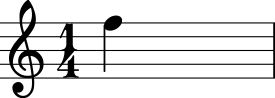

In [ ]:
f.show()

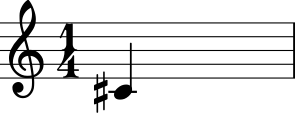

In [ ]:
a = note.Note("C#4")
a.show()

In [ ]:
parsed = music21.converter.parse('/content/transcribed (5).mid')

In [ ]:
!pip install pytube

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pytube import YouTube
from pydub import AudioSegment

In [ ]:
wav_path = "wav_data"

def download_and_convert_wav():
    if not os.path.exists(wav_path): os.mkdir(wav_path)
    singer_song = input("가수 - 제목: ")
    yt = YouTube(input("음원 유튜브 url: "))
    yt.streams.filter(only_audio=True).first().download(output_path=wav_path, filename=singer_song+".mp3")
    AudioSegment.from_file(os.path.join(wav_path, singer_song+".mp3")).export(os.path.join(wav_path, singer_song+".wav"), format="wav")
    os.remove(os.path.join(wav_path, singer_song+".mp3"))

In [ ]:
download_and_convert_wav()

가수 - 제목: 폴킴 - 커피 한 잔 할래요
음원 유튜브 url: https://www.youtube.com/watch?v=JaA8KuRAFCs


# wav -> chord or note

In [ ]:
keyboard_nstrument = ["KeyboardInstrument", "Piano", "Harpsichord", "Clavichord", "Celesta", ]

In [ ]:
def get_notes_chords_rests(instrument_type, path):
    try:
        midi = converter.parse(path)
        parts = instrument.partitionByInstrument(midi)
        note_list = []
        for music_instrument in range(len(parts)):
            if parts.parts[music_instrument].id in instrument_type:
                for element_by_offset in stream.iterator.OffsetIterator(parts[music_instrument]):
                    for entry in element_by_offset:
                        if isinstance(entry, note.Note):
                            note_list.append(str(entry.pitch))
                        elif isinstance(entry, chord.Chord):
                            note_list.append('.'.join(str(n) for n in entry.normalOrder))
                        elif isinstance(entry, note.Rest):
                            note_list.append('Rest')
        return note_list
    except Exception as e:
        print("failed on ", path)
        pass

In [ ]:
notes = get_notes_chords_rests("Piano", "/content/transcribed (5).mid")

In [ ]:
notes

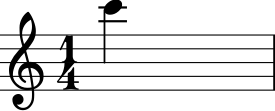

In [ ]:
cMajor = chord.Chord([notes[20]])
cMajor.show()

In [ ]:
!pip install chord-extractor

In [ ]:
from chord_extractor.extractors import Chordino
from chord_extractor import clear_conversion_cache, LabelledChordSequence

files_to_extract_from = [
  '/content/transcribed (5).mid'
]

def save_to_db_cb(results: LabelledChordSequence):
    # Every time one of the files has had chords extracted, receive the chords here 
    # along with the name of the original file and then run some logic here, e.g. to 
    # save the latest data to DB

    chordino = Chordino()

    # Optionally clear cache of file conversions (e.g. wav files that have been converted from midi)
    clear_conversion_cache()

    # Run bulk extraction
    res = chordino.extract_many(files_to_extract_from, callback=save_to_db_cb, num_extractors=2,
                                num_preprocessors=2, max_files_in_cache=10, stop_on_error=False)
    # => LabelledChordSequence(
    #	id='/tmp/extractor/d8b8ab2f719e8cf40e7ec01abd116d3a', 
    #	sequence=[ChordChange(chord='N', timestamp=0.371519274), 
    #	    ChordChange(chord='C', timestamp=0.743038548), 
    #	    ChordChange(chord='Am7b5', timestamp=8.54494331),...])

In [ ]:
save_to_db_cb(files_to_extract_from)